In [42]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# %load load_save.py
# Database load and store functions 
# This file is meant to be %load'ed at the top of the
# various model-run notebooks


%load_ext sql

%config SqlMagic.autopandas = True 

%sql postgresql://localhost/bankcalls
    

import os.path
import pickle

from string import Template

def store_results(m):
    filename = m['name'] + '_' + m['strategy'] + '.pkl'
    dirname = '../data/inter/'
    pathname = dirname + filename
    
    count = 0
    while os.path.isfile(pathname):
        pathname = (dirname + 
                    m['name'] + 
                    '_' + 
                    m['strategy'] + 
                    str(count) +
                    '.pkl'
                   )
        count += 1
                    
    f = open(pathname, 'w+b')
    pickle.dump(m, f)
    f.close()
    
    # all the quotes and brackets seem to confuse %sql so I'm templating
    # the command manually
    sqlt = Template("""INSERT 
        INTO test_results(pathname, accuracy, recall, precision, 
                            f1, auc, cm_00, cm_01, cm_10, cm_11) 
        VALUES  ($pg_path, $accuracy, $recall, $precision, 
                            $f1, $auc, $cm_00, $cm_01, $cm_10, $cm_11);""")
    sqlins = sqlt.substitute(pg_path = "'" + pathname + "'",
                    accuracy = m['accuracy'],
                    recall = m['recall'],
                    precision = m['precision'],
                    f1 = m['f1'],
                    auc = m['auc'],
                    cm_00 = m['cm'][0,0],
                    cm_01 = m['cm'][0,1],
                    cm_10 = m['cm'][1,0],
                    cm_11 = m['cm'][1,1]
                   )
    %sql $sqlins
                    
    return pathname
    
        
def load_results(path):
    f = open(path, 'r+b')
    m = pickle.load(f)
    return m

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [44]:
%%sql
SELECT pathname, 
        precision cv_precision, 
        recall cv_recall, 
        f1 cv_f1, 
        auc cv_auc 
FROM test_results;

 * postgresql://localhost/bankcalls
24 rows affected.


,pathname,cv_precision,cv_recall,cv_f1,cv_auc
0,../data/inter/logi-eda-ros_ros.pkl,0.321324,0.651131,0.430301,0.794002
1,../data/inter/logi-eda-l1_ros.pkl,0.246858,0.719558,0.367603,0.746322
2,../data/inter/logi-eda-smote_smote.pkl,0.317076,0.649784,0.426186,0.790426
3,../data/inter/logi-eda-l1_smote.pkl,0.246858,0.719558,0.367603,0.746138
4,../data/inter/logi-context_ros.pkl,0.246359,0.715517,0.366522,0.729409
5,../data/inter/logi-context-l1_ros.pkl,0.246858,0.719558,0.367603,0.748922
6,../data/inter/logi-all-ros_ros.pkl,0.329624,0.646282,0.436579,0.795784
7,../data/inter/logi-all-l1_ros.pkl,0.246858,0.719558,0.367603,0.748922
8,../data/inter/logi-all_smote.pkl,0.235525,0.710129,0.353731,0.746450
9,../data/inter/rf_eda_down.pkl,0.334580,0.723060,0.457474,0.846988


In [45]:
candidates = _
candidates = candidates.set_index("pathname", drop=True);

In [46]:
df = candidates[['cv_f1', 'cv_auc']].copy()

In [47]:
holdout = {}

In [48]:
for path in candidates.index:
    data = load_results(path)
    holdout[path] = data['holdout']
    df.loc[path, 'test_f1'] = holdout[path]['f1']
    df.loc[path, 'test_auc'] = holdout[path]['auc']
    df.loc[path, 'test_precision'] = holdout[path]['precision']
    df.loc[path, 'test_recall'] = holdout[path]['recall']
    df.loc[path, 'test_accuracy'] = holdout[path]['accuracy']

In [52]:
hdf = pd.DataFrame(holdout).T
hdf = hdf.drop(columns=['probs','thresholds','tpr','fpr'])

In [53]:
df.round(decimals=4)

,cv_f1,cv_auc,test_f1,test_auc,test_precision,test_recall,test_accuracy
pathname,,,,,,,
../data/inter/logi-eda-ros_ros.pkl,0.4303,0.7940,0.4163,0.7790,0.3119,0.6261,0.8023
../data/inter/logi-eda-l1_ros.pkl,0.3676,0.7463,0.3494,0.7222,0.2353,0.6789,0.7152
../data/inter/logi-eda-smote_smote.pkl,0.4262,0.7904,0.4164,0.7764,0.3122,0.6250,0.8026
../data/inter/logi-eda-l1_smote.pkl,0.3676,0.7461,0.3494,0.7219,0.2353,0.6789,0.7152
../data/inter/logi-context_ros.pkl,0.3665,0.7294,0.3490,0.7108,0.2351,0.6767,0.7156
../data/inter/logi-context-l1_ros.pkl,0.3676,0.7489,0.3494,0.7218,0.2353,0.6789,0.7152
../data/inter/logi-all-ros_ros.pkl,0.4366,0.7958,0.4214,0.7787,0.3196,0.6185,0.8087
../data/inter/logi-all-l1_ros.pkl,0.3676,0.7489,0.3494,0.7218,0.2353,0.6789,0.7152
../data/inter/logi-all_smote.pkl,0.3537,0.7465,0.3386,0.7272,0.2268,0.6681,0.7060


In [69]:
top_f1 = df.sort_values('test_f1', ascending=False).iloc[:5,:]
top_auc = df.sort_values('test_auc', ascending=False).iloc[:5,:]

subset = set(top_f1.index)
subset.update(top_auc.index)

In [70]:
df = df.loc[list(subset)]
df.shape

(10, 7)

In [71]:
cm_data = pd.DataFrame(columns=['False_Pos', 'False_Neg', 'True_Pos'])
    
for b in subset:
    cm = holdout[b]['cm']
    cm_data.loc[b, 'True_Neg'] = cm[0,0] 
    cm_data.loc[b, 'False_Pos'] = cm[0,1]
    cm_data.loc[b, 'False_Neg'] = cm[1,0]
    cm_data.loc[b, 'True_Pos']  = cm[1,1]
    cm_data.loc[b, 'test_f1'] = df.loc[b].test_f1
    cm_data.loc[b, 'test_auc'] = df.loc[b].test_auc
    cm_data.loc[b, 'test_precision'] = holdout[b]['precision']
    cm_data.loc[b, 'test_recall']    = holdout[b]['recall']
    cm_data.loc[b, 'test_accuracy']  = holdout[b]['accuracy']
  

In [72]:
index = [i.replace('../data/inter/', '') for i in cm_data.index]
index = [i.replace('.pkl', '') for i in index]
cm_data.index = index

In [73]:
cm_data

,False_Pos,False_Neg,True_Pos,True_Neg,test_f1,test_auc,test_precision,test_recall,test_accuracy
logi-eda-smote_smote,1278.0,348.0,580.0,6032.0,0.416368,0.776366,0.312164,0.625000,0.802622
rf_all10_smote,628.0,442.0,486.0,6682.0,0.476004,0.766656,0.436266,0.523707,0.870114
rf_context_ros,812.0,389.0,539.0,6498.0,0.473014,0.770852,0.398964,0.580819,0.854212
gb_eda_ros,1002.0,356.0,572.0,6308.0,0.457234,0.780164,0.363405,0.616379,0.835154
gb_all_smote,424.0,516.0,412.0,6886.0,0.467120,0.764739,0.492823,0.443966,0.885895
logi-all-ros_ros,1222.0,354.0,574.0,6088.0,0.421439,0.778704,0.319599,0.618534,0.808691
logi-eda-ros_ros,1282.0,347.0,581.0,6028.0,0.416338,0.779042,0.311863,0.626078,0.802258
gb_context_ros,809.0,390.0,538.0,6501.0,0.472967,0.770541,0.399406,0.579741,0.854455
gb_context_smote,914.0,377.0,551.0,6396.0,0.460510,0.778185,0.376109,0.593750,0.843287
rf_all10_ros,823.0,378.0,550.0,6487.0,0.478053,0.774015,0.400583,0.592672,0.854212


In [74]:
cm_data = cm_data.sort_values('True_Pos', ascending=False)

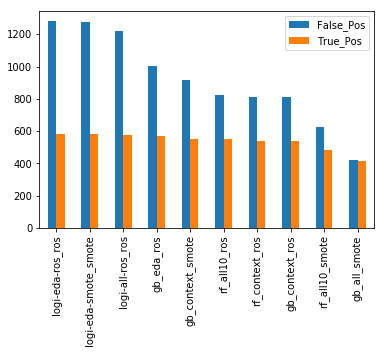

In [75]:
cm_data.loc[:,['False_Pos', 'True_Pos']].plot(kind='bar')


In [76]:
cm_data

,False_Pos,False_Neg,True_Pos,True_Neg,test_f1,test_auc,test_precision,test_recall,test_accuracy
logi-eda-ros_ros,1282.0,347.0,581.0,6028.0,0.416338,0.779042,0.311863,0.626078,0.802258
logi-eda-smote_smote,1278.0,348.0,580.0,6032.0,0.416368,0.776366,0.312164,0.625000,0.802622
logi-all-ros_ros,1222.0,354.0,574.0,6088.0,0.421439,0.778704,0.319599,0.618534,0.808691
gb_eda_ros,1002.0,356.0,572.0,6308.0,0.457234,0.780164,0.363405,0.616379,0.835154
gb_context_smote,914.0,377.0,551.0,6396.0,0.460510,0.778185,0.376109,0.593750,0.843287
rf_all10_ros,823.0,378.0,550.0,6487.0,0.478053,0.774015,0.400583,0.592672,0.854212
rf_context_ros,812.0,389.0,539.0,6498.0,0.473014,0.770852,0.398964,0.580819,0.854212
gb_context_ros,809.0,390.0,538.0,6501.0,0.472967,0.770541,0.399406,0.579741,0.854455
rf_all10_smote,628.0,442.0,486.0,6682.0,0.476004,0.766656,0.436266,0.523707,0.870114
gb_all_smote,424.0,516.0,412.0,6886.0,0.467120,0.764739,0.492823,0.443966,0.885895


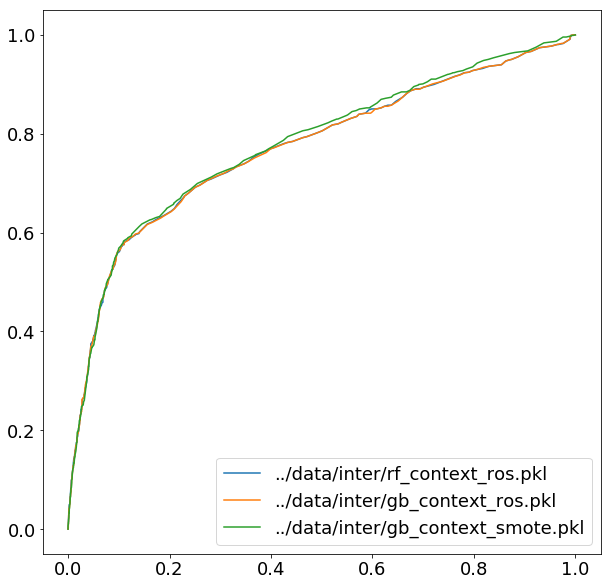

In [80]:
plt.figure(figsize=(10,10))
for s in subset:
    d = holdout[s]
    if s.find("context") != -1:
        plt.plot(d['fpr'], d['tpr'], label=s)
plt.legend(loc='lower right')
plt.show()

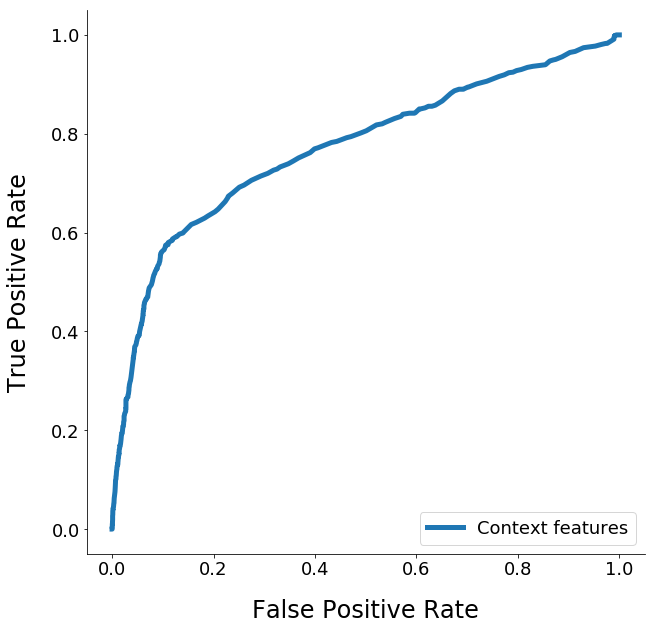

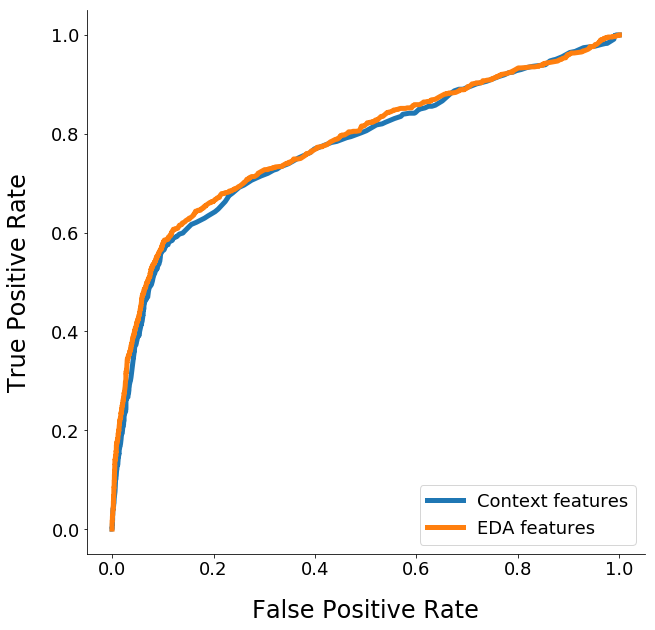

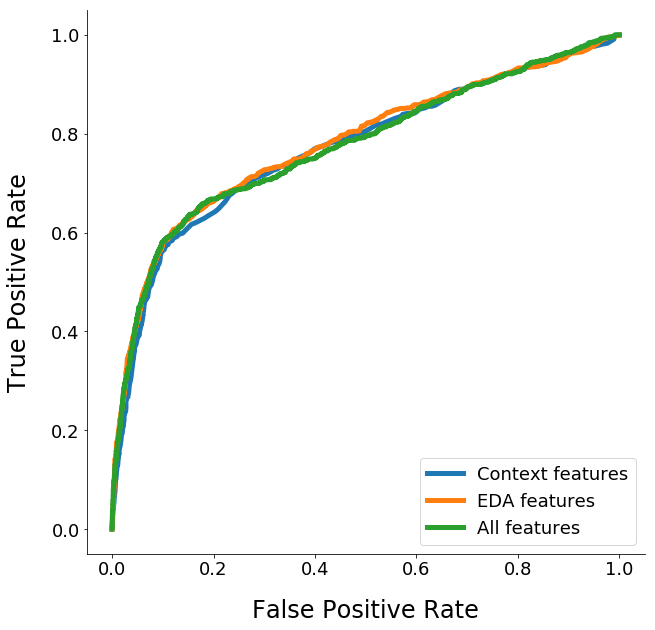

In [108]:
context = '../data/inter/gb_context_ros.pkl'
eda = '../data/inter/gb_eda_ros.pkl'
allc = '../data/inter/rf_all10_ros.pkl'

import matplotlib

font = { 'size'   : 18 }

matplotlib.rc('font', **font)


def fixplot():
    plt.legend(loc='lower right')
    ax = plt.gca()
    ax.set_xlabel("False Positive Rate", labelpad=20, fontsize=24)
    ax.set_ylabel("True Positive Rate", labelpad=20, fontsize=24)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.figure(figsize=(10,10))
d = holdout[context]
plt.plot(d['fpr'], d['tpr'], linewidth=5, label='Context features')
fixplot()
plt.savefig('context.svg')
plt.show()

plt.figure(figsize=(10,10))
d = holdout[context]
plt.plot(d['fpr'], d['tpr'], linewidth=5, label='Context features')
d = holdout[eda]
plt.plot(d['fpr'], d['tpr'], linewidth=5, label='EDA features')
fixplot()
plt.savefig('eda.svg')
plt.show()

plt.figure(figsize=(10,10))
d = holdout[context]
plt.plot(d['fpr'], d['tpr'], linewidth=5, label='Context features')
d = holdout[eda]
plt.plot(d['fpr'], d['tpr'], linewidth=5, label='EDA features')
d = holdout[allc]
plt.plot(d['fpr'], d['tpr'], linewidth=5, label='All features')
fixplot()
plt.savefig('all.svg')
plt.show()

In [109]:
auc_sort = cm_data.sort_values('test_auc', ascending=False)
auc_sort.head()

,False_Pos,False_Neg,True_Pos,True_Neg,test_f1,test_auc,test_precision,test_recall,test_accuracy
gb_eda_ros,1002.0,356.0,572.0,6308.0,0.457234,0.780164,0.363405,0.616379,0.835154
logi-eda-ros_ros,1282.0,347.0,581.0,6028.0,0.416338,0.779042,0.311863,0.626078,0.802258
logi-all-ros_ros,1222.0,354.0,574.0,6088.0,0.421439,0.778704,0.319599,0.618534,0.808691
gb_context_smote,914.0,377.0,551.0,6396.0,0.460510,0.778185,0.376109,0.593750,0.843287
logi-eda-smote_smote,1278.0,348.0,580.0,6032.0,0.416368,0.776366,0.312164,0.625000,0.802622


In [110]:
f1_sort = cm_data.sort_values('test_f1', ascending=False)
f1_sort.head()

,False_Pos,False_Neg,True_Pos,True_Neg,test_f1,test_auc,test_precision,test_recall,test_accuracy
rf_all10_ros,823.0,378.0,550.0,6487.0,0.478053,0.774015,0.400583,0.592672,0.854212
rf_all10_smote,628.0,442.0,486.0,6682.0,0.476004,0.766656,0.436266,0.523707,0.870114
rf_context_ros,812.0,389.0,539.0,6498.0,0.473014,0.770852,0.398964,0.580819,0.854212
gb_context_ros,809.0,390.0,538.0,6501.0,0.472967,0.770541,0.399406,0.579741,0.854455
gb_all_smote,424.0,516.0,412.0,6886.0,0.467120,0.764739,0.492823,0.443966,0.885895


In [111]:
slides = [context,eda,allc]
slides = [ s.replace(".pkl", "") for s in slides ]
slides = [ s.replace("../data/inter/","") for s in slides ]
slide_data = cm_data.loc[slides,:].reset_index()

In [112]:
columns =  list(slide_data.columns)
columns = ['name'] + columns[1:]
slide_data.columns = columns
slide_data

,name,False_Pos,False_Neg,True_Pos,True_Neg,test_f1,test_auc,test_precision,test_recall,test_accuracy
0,gb_context_ros,809.0,390.0,538.0,6501.0,0.472967,0.770541,0.399406,0.579741,0.854455
1,gb_eda_ros,1002.0,356.0,572.0,6308.0,0.457234,0.780164,0.363405,0.616379,0.835154
2,rf_all10_ros,823.0,378.0,550.0,6487.0,0.478053,0.774015,0.400583,0.592672,0.854212


In [113]:
slide_data.name = ['Context', 'EDA', 'All']
slide_data = slide_data.loc[:,['name','True_Pos', 'False_Pos'] ]
slide_data

,name,True_Pos,False_Pos
0,Context,538.0,809.0
1,EDA,572.0,1002.0
2,All,550.0,823.0


In [114]:
slide_data

,name,True_Pos,False_Pos
0,Context,538.0,809.0
1,EDA,572.0,1002.0
2,All,550.0,823.0


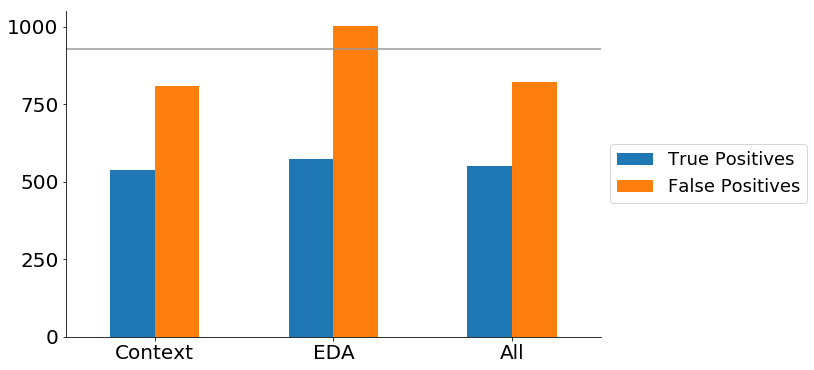

In [115]:
ax = slide_data.loc[:,['True_Pos','False_Pos']].plot(kind='bar', figsize=(12,6),
                                                    yticks=[0, 250, 500, 750, 1000], fontsize=20)
ax.set_xticklabels(slide_data.name.values)
for tick in ax.get_xticklabels():
        tick.set_rotation(0)
        
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
xmin,xmax = ax.get_xlim()
        
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(['True Positives', 'False Positives'], loc='center left', bbox_to_anchor=(1, 0.5))
ax.axhline(928, xmin, xmax, color=(.6,.6,.6))
plt.savefig('bars.svg')
